In [16]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import os

plt.rcParams["figure.dpi"] = 300
sns.set_style("white")
os.makedirs('../cleaned_data/filted_data', exist_ok=True)

Derivating the list of restaurants' ids in the specified area (`loc_food_id`).

In [5]:
business = pd.read_json("../yelp_dataset/yelp_academic_dataset_business.json", lines=True)

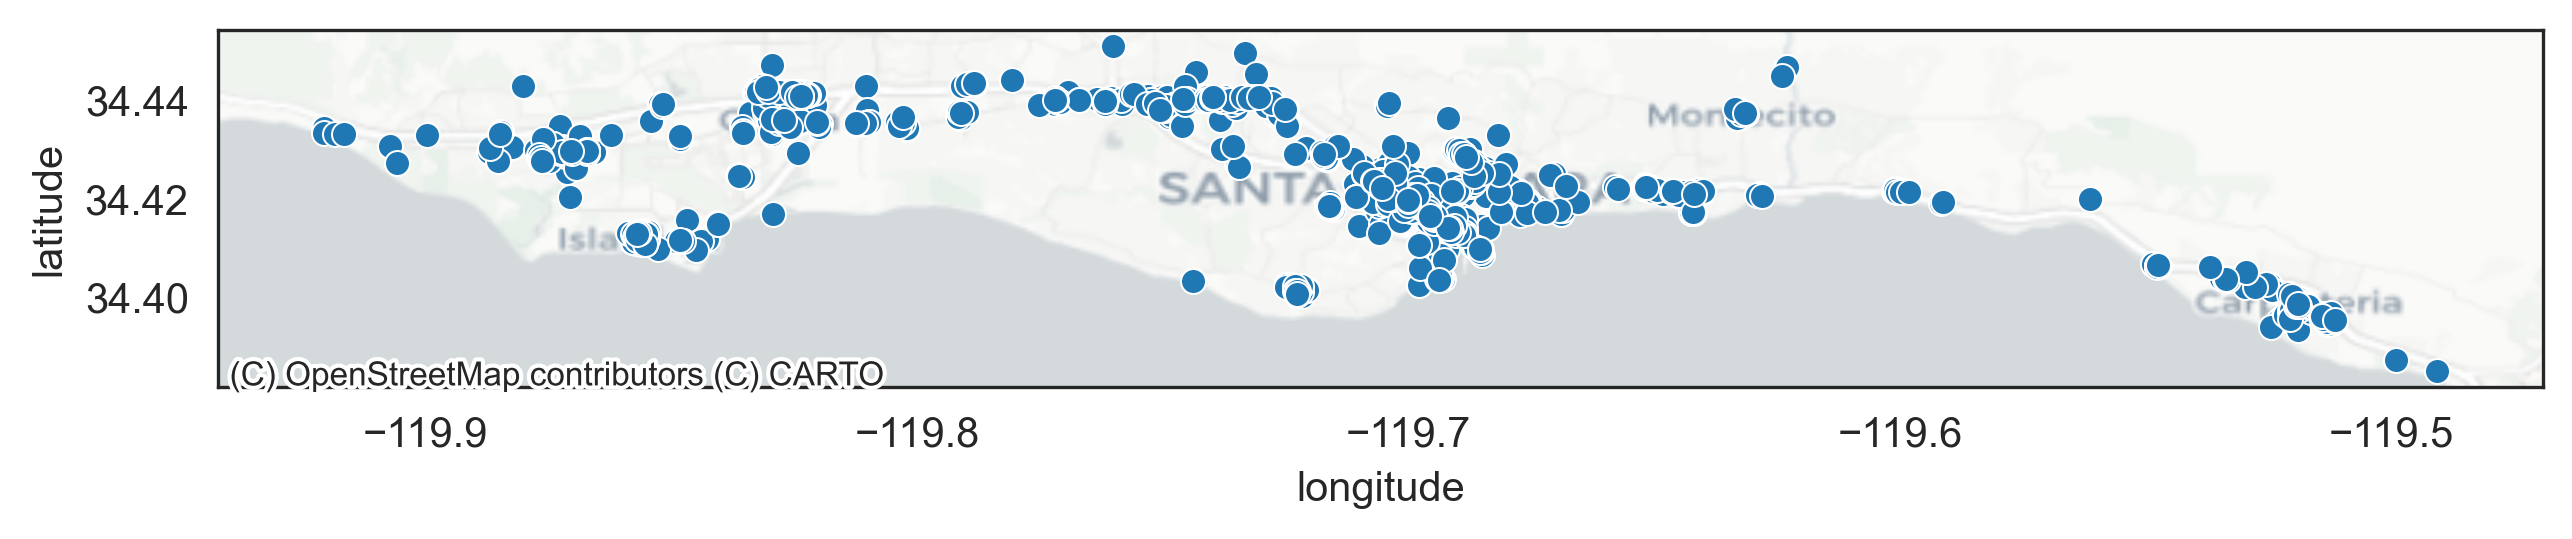

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    data=business[["latitude", "longitude"]], x="longitude", y="latitude", ax=ax
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326") # stamen of old version has been removed
plt.show()

In [7]:
loc = (business["latitude"] < 34.5) * (business["longitude"] < -115)
food = business["categories"].map(
    lambda x: "Food" in x.split(", ") or "Restaurants" in x.split(", ") if x else False
)
loc_food_id = business[loc * food]["business_id"].to_list()
len(loc_food_id)

1586

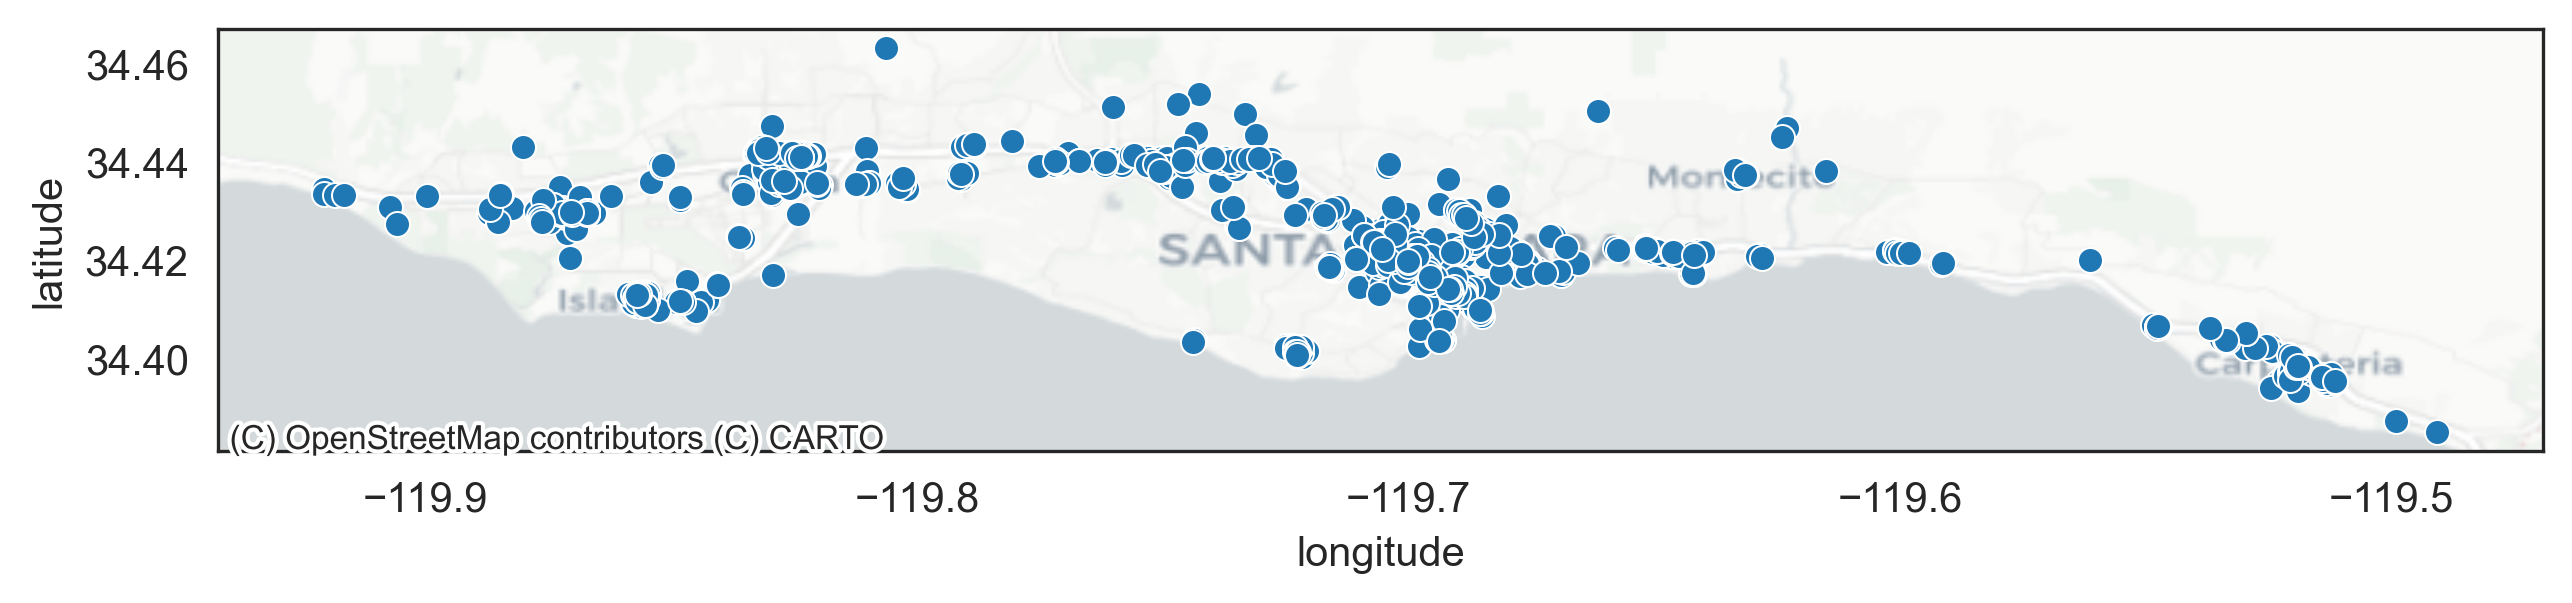

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    data=business[loc * food][["latitude", "longitude"]],
    x="longitude",
    y="latitude",
    ax=ax,
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326")

In [9]:
checkin = pd.read_json("../yelp_dataset/yelp_academic_dataset_checkin.json", lines=True)

In [10]:
loc_food_id = [i for i in loc_food_id if i in checkin["business_id"].to_list()]
len(loc_food_id)

1527

Filtering the datasets with `loc_food_id` and saving.

In [11]:
tip = pd.read_json("../yelp_dataset/yelp_academic_dataset_tip.json", lines=True)

In [12]:
review_dataset = load_dataset("json", data_files="../yelp_dataset/yelp_academic_dataset_review.json")

Generating train split: 6990280 examples [00:08, 815302.37 examples/s]


In [13]:
business = business[business["business_id"].apply(lambda x: x in loc_food_id)]
checkin = checkin[checkin["business_id"].apply(lambda x: x in loc_food_id)]
tip = tip[tip["business_id"].apply(lambda x: x in loc_food_id)]
review = review_dataset.filter(lambda x: x["business_id"] in loc_food_id)
review = review["train"].to_pandas()

Filter: 100%|██████████| 6990280/6990280 [02:48<00:00, 41513.33 examples/s]


In [17]:
business.to_csv("../cleaned_data/filted_data/business.csv", index=False)
checkin.to_csv("../cleaned_data/filted_data/checkin.csv", index=False)
tip.to_csv("../cleaned_data/filted_data/tip.csv", index=False)
review.to_json("../cleaned_data/filted_data/review.json", orient="split", index=False)

Derivating the list of users' ids who had written a tip/review for those restaurants (`loc_food_user`).

In [18]:
loc_food_user = set(tip["user_id"].tolist() + review["user_id"].tolist())
len(loc_food_user)

116632

Filtering the dataset with `loc_food_user` and saving.

In [19]:
user_dataset = load_dataset("json", data_files="../yelp_dataset/yelp_academic_dataset_user.json")

Generating train split: 1987897 examples [00:05, 333446.07 examples/s]


In [20]:
user = user_dataset.filter(lambda x: x["user_id"] in loc_food_user)
user = user["train"].to_pandas()
user["friends"] = user["friends"].apply(lambda x: [i for i in x.split(", ") if i in loc_food_user] if x else [])

Filter: 100%|██████████| 1987897/1987897 [00:27<00:00, 70999.56 examples/s]


In [21]:
user.to_csv("../cleaned_data/filted_data/user.csv", index=False)